<a href="https://colab.research.google.com/github/mgiorgi13/GNN_Notebooks/blob/main/Graph%20Level%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands on with Graph Neural Networks

## Setup

In [35]:
#Colab
#from google.colab import drive
#drive.mount('/content/drive')
#GNN_PATH = '/content/drive/MyDrive/Colab Notebooks/GNN/'

#HPC
GNN_PATH = './Colab Notebooks/GNN/'
import os
if not os.path.exists(GNN_PATH):
    os.makedirs(GNN_PATH)

- Pytorch Geometric => Build Graph Neural Network
- RDKit => Handle Molecule Data

In [36]:
# Install packages in the virtual environment
!pip install rdkit torch torch-geometric scikit-learn matplotlib seaborn

# Check pytorch version and make sure you use a GPU Kernel
!python3 -c "import torch; print(torch.__version__)"
!python3 -c "import torch; print(torch.version.cuda)"
!python3 --version
!nvidia-smi

You should consider upgrading via the '/mnt/aiongpfs/users/mgiorgi/venv_aion/bin/python -m pip install --upgrade pip' command.
2.4.1+cu121
12.1
Python 3.8.6
Fri Apr  4 17:15:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:1A:00.0 Off |                    0 |
| N/A   45C    P0             61W /  300W |     412MiB /  32768MiB |      0

## Background info on the Dataset

In the following we will use a dataset provided in the dataset collection of PyTorch Geometric ([Here you find all datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)). The Dataset comes from the MoleculeNet collection, which can be found [here](http://moleculenet.ai/datasets-1).


>"ESOL is a small dataset consisting of water solubility data for 1128 compounds. The dataset
has been used to train models that estimate solubility directly from chemical structures (as
encoded in SMILES strings). Note that these structures don’t include 3D coordinates, since
solubility is a property of a molecule and not of its particular conformers."

**>>> Machine Learning task: How are different molecules dissolving in water?**


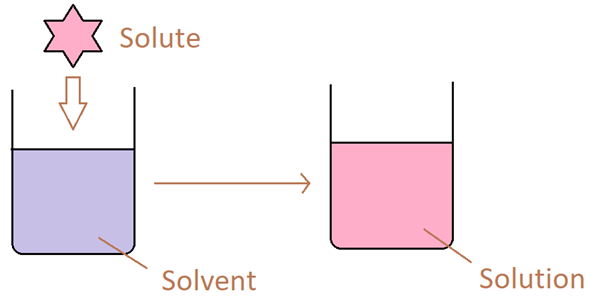

Source: https://www.differencebetween.com/difference-between-solubility-and-solubility-product/

### SMILES representation and important sidenodes

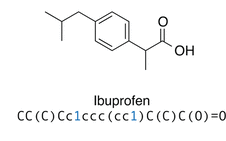

 Source: https://medium.com/@sunitachoudhary103/generating-molecules-using-a-char-rnn-in-pytorch-16885fd9394b

- Using the plain SMILES string as input is not suitable
- This will not consider the molecule structure but rather the grammar of the SMILES string
- The SMILES string can be different for a molecule, depending on the notation ( a unique molecule can have multiple SMILES strings )
- Chemical graphs however, are invariant to permutations --> Graph Neural Networks


## Looking into the Dataset

In [37]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

ESOL(1128)

In [38]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [39]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [40]:
# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [41]:
data[0].y

tensor([[-0.7700]])

In the following we will perform predictions based on the graph level. This means we have one y-label for the whole graph.

## Converting SMILES to RDKit molecules - Visualizing molecules

Next we want to have our SMILES molecules as graphs...

In [42]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

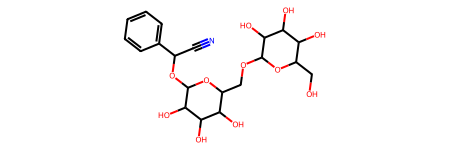

In [43]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [44]:
type(molecule)

rdkit.Chem.rdchem.Mol

- We can also obtain the features from this RDKit representation
- It tells us everything we need to know e.g. atom features (type, ...), edges, ...
- **In our case however, It's even easier as we have the information explicitly given already in the dataset**
- Otherwise we would calculate the node features from those atom properties

-> For datasets containing SMILES representations this would be the way to go

## Implementing the Graph Neural Network

Building a Graph Neural Network works the same way as building a Convolutional Neural Network, we simple add some layers.

The GCN simply extends torch.nn.Module.
GCNConv expects:
- in_channels = Size of each input sample.
- out_channels = Size of each output sample.

We apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

Always keep in mind that different learning problems (node, edge or graph prediction) require different GNN architectures.

For example for node-level prediction you will often encounter masks. For graph-level predictions on the other hand you need to combine the node embeddings.

First set seed for reproducibility 

In [45]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed once at the beginning
set_seed(42)

# For reproducible DataLoader shuffle
g = torch.Generator()
g.manual_seed(42)

train_loader = DataLoader(train_data, shuffle=True, batch_size=64, generator=g)
val_loader = DataLoader(val_data, shuffle=False, batch_size=64)


In [46]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


- We could also reduce the embeddings, but as we have large molecules we use 64
- The more layers we add, the more information we get about the graph
- For the regression problem we use a Linear layer as final output layer
- We try to use not too many parameters, as we only have ~1k samples

## Training the GNN

Divide dataset in training validation and test sets. We will use validation to perform early-stopping

In [57]:
from torch_geometric.data import DataLoader
import torch
import warnings

warnings.filterwarnings("ignore")

# Define loss function: Mean Squared Error
loss_fn = torch.nn.MSELoss()

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define number of graphs per batch
NUM_GRAPHS_PER_BATCH = 64

# Split dataset: 70% train, 10% validation, 20% test
data_size = len(data)
train_data = data[:int(data_size * 0.7)]
val_data = data[int(data_size * 0.7):int(data_size * 0.8)]
test_data = data[int(data_size * 0.8):]

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
val_loader = DataLoader(val_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)
test_loader = DataLoader(test_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

In [48]:
# Training function
def train(loader):
    model.train()  # Set the model to training mode (enables layers like dropout)
    total_loss = 0  # Accumulator for the total loss

    for batch in loader:  # Iterate through each batch of data
        batch = batch.to(device)  # Move the batch to GPU (or CPU)

        optimizer.zero_grad()  # Clear previously accumulated gradients

        # Forward pass: predict outputs and extract embeddings
        pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)

        # Compute the loss between predictions and true labels
        loss = loss_fn(pred, batch.y)

        total_loss += loss.item()  # Add current loss to total (as float)

        loss.backward()  # Compute gradients via backpropagation
        optimizer.step()  # Update model parameters based on gradients

    # Return the average loss over all batches and the final batch's embedding
    return total_loss / len(loader), embedding


# Validation/Test function
def evaluate(loader):
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    total_loss = 0  # Accumulator for validation loss

    with torch.no_grad():  # Disable gradient computation for faster evaluation
        for batch in loader:
            batch = batch.to(device)

            # Forward pass to get predictions; embeddings are ignored here
            pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)

            # Compute loss on validation/test data
            loss = loss_fn(pred, batch.y)

            total_loss += loss.item()  # Accumulate loss as float

    # Return average loss over all validation/test batches
    return total_loss / len(loader)


In [58]:
# Paths for saving models
best_val_model_path = os.path.join(GNN_PATH, 'best_val_model.pt')
final_model_path = os.path.join(GNN_PATH, 'final_model.pt')

# Early stopping parameters
best_val_loss = float('inf')
patience = 500
patience_counter = 0
epoch_number = 2000
best_epoch = -1  # To track when best model was found

train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(epoch_number):
    # Train for one epoch
    train_loss, _ = train(train_loader)
    # Evaluate on validation set
    val_loss = evaluate(val_loader)
    # Accumulate Losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check if validation improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_epoch = epoch
        # Save the best model seen so far
        torch.save(model.state_dict(), best_val_model_path)
    else:
        patience_counter += 1

    # Print progress every 100 epochs
    if epoch % 100 == 0 or epoch == epoch_number - 1:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping check
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save the final model
torch.save(model.state_dict(), final_model_path)
print("\nTraining completed.")

Starting training...
Epoch 0 | Train Loss: 10.9396 | Val Loss: 12.5818
Epoch 100 | Train Loss: 0.7775 | Val Loss: 0.7628
Epoch 200 | Train Loss: 0.5802 | Val Loss: 0.6597
Epoch 300 | Train Loss: 0.4602 | Val Loss: 0.8108
Epoch 400 | Train Loss: 0.4655 | Val Loss: 0.5111
Epoch 500 | Train Loss: 0.3965 | Val Loss: 0.4248
Epoch 600 | Train Loss: 0.3868 | Val Loss: 0.5584
Epoch 700 | Train Loss: 0.3367 | Val Loss: 0.6455
Epoch 800 | Train Loss: 0.3441 | Val Loss: 0.6237
Epoch 900 | Train Loss: 0.2606 | Val Loss: 0.5126
Epoch 1000 | Train Loss: 0.2690 | Val Loss: 0.4827
Epoch 1100 | Train Loss: 0.2559 | Val Loss: 0.5196
Early stopping triggered at epoch 1131.

Training completed.


### Visualizing the Training loss

In [59]:
# Function for visualize the embedding
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings(embeddings, targets, epoch):
    # Convert to numpy
    emb = embeddings.cpu().detach().numpy()
    y = targets.cpu().detach().numpy()

    # Reduce to 2D
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(emb)

    # Plot
    plt.figure(figsize=(6, 6))
    sc = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=y, cmap='viridis', alpha=0.8)
    plt.colorbar(sc, label='Target Value')
    plt.title(f"t-SNE of Embeddings at Epoch {epoch}")
    plt.tight_layout()
    plt.show()

Final Model Evaluation:
Train Loss: 0.1906
Val Loss:   0.6289


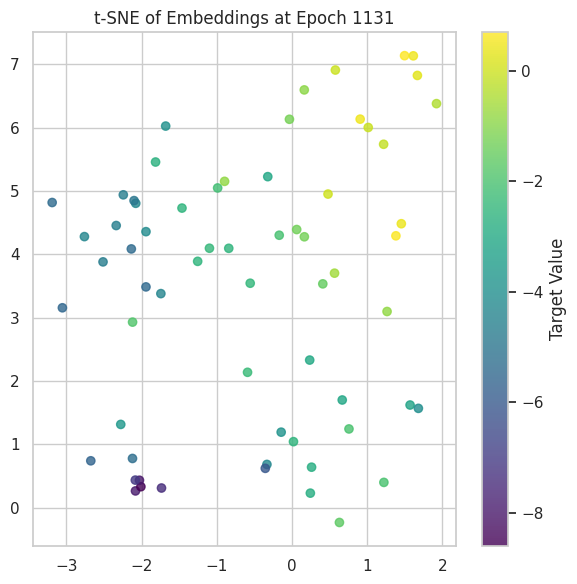


Early-Stopped Model Evaluation:
Train Loss: 0.1708
Val Loss:   0.4017
Model was saved at epoch 631.


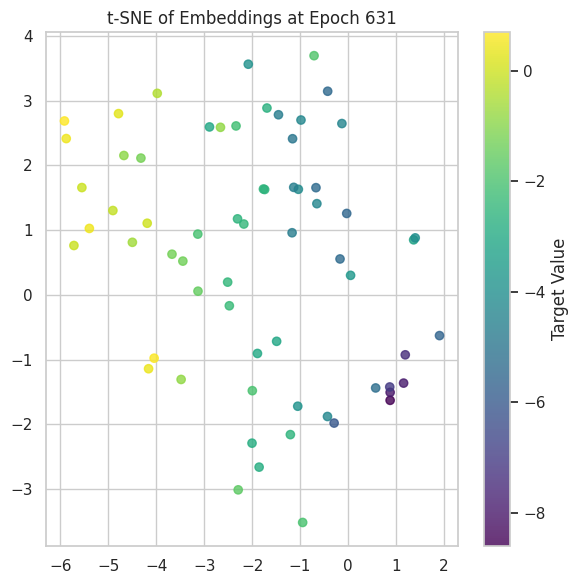

In [60]:
# Load and evaluate the final model
model.load_state_dict(torch.load(final_model_path))
final_train_loss = evaluate(train_loader)
final_val_loss = evaluate(val_loader)

print("Final Model Evaluation:")
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Val Loss:   {final_val_loss:.4f}")
# Take a batch from validation (or train) set for visualization
val_batch = next(iter(val_loader))
val_batch = val_batch.to(device)
with torch.no_grad():
    _, val_embedding = model(val_batch.x.float(), val_batch.edge_index, val_batch.batch)
plot_embeddings(val_embedding, val_batch.y, epoch)

model.load_state_dict(torch.load(best_val_model_path))
best_train_loss = evaluate(train_loader)
best_val_loss_eval = evaluate(val_loader)

print("\nEarly-Stopped Model Evaluation:")
print(f"Train Loss: {best_train_loss:.4f}")
print(f"Val Loss:   {best_val_loss_eval:.4f}")
print(f"Model was saved at epoch {best_epoch}.")
val_batch = val_batch.to(device)
with torch.no_grad():
    _, val_embedding = model(val_batch.x.float(), val_batch.edge_index, val_batch.batch)
plot_embeddings(val_embedding, val_batch.y, best_epoch)

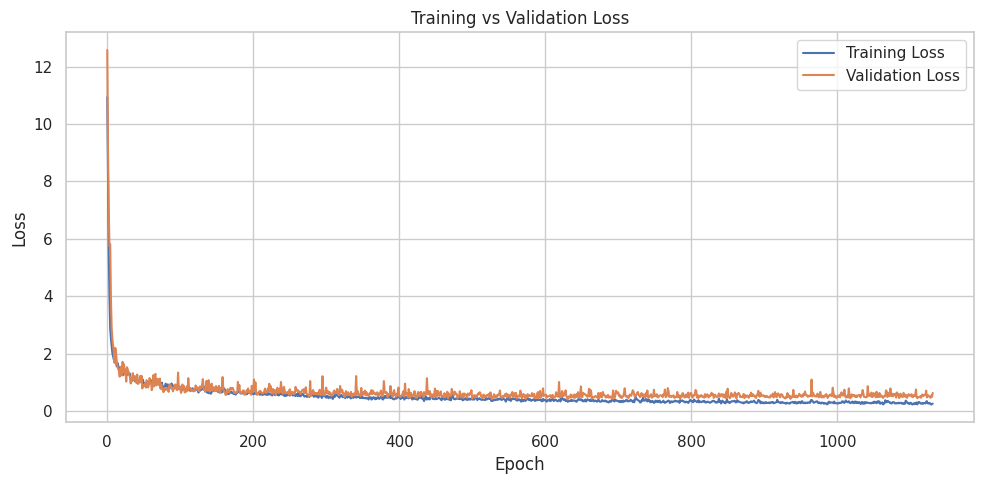

In [61]:
import seaborn as sns

# Make sure seaborn uses a clean style
sns.set(style="whitegrid")

# X-axis: epoch numbers
epochs = list(range(len(train_losses)))

# Create the plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=epochs, y=train_losses, label="Training Loss")
sns.lineplot(x=epochs, y=val_losses, label="Validation Loss")

# Add labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

### Getting a test prediction

In [62]:
import pandas as pd

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-5.190,-2.837787
1,-0.660,-0.193879
2,-4.100,-3.282898
3,-3.900,-3.546016
4,-4.720,-3.816570
...,...,...
59,-5.284,-4.968668
60,-6.140,-6.042351
61,-6.020,-4.885231
62,-4.460,-4.469858


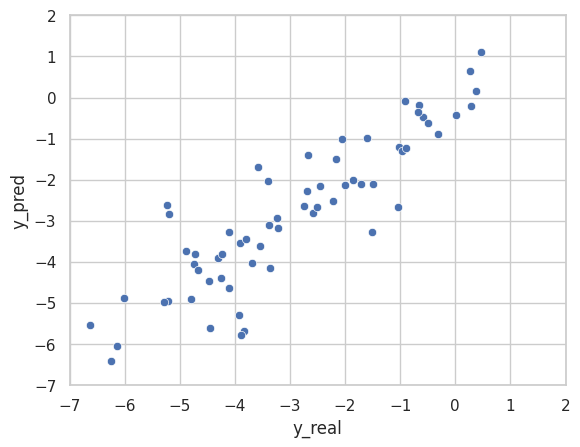

In [63]:
ax = sns.scatterplot(data=df, x="y_real", y="y_pred")
ax.set_xlim(-7, 2)
ax.set_ylim(-7, 2)
plt.show()

## Improving the model

For example add:
- Dropouts
- Other (more intelligent) Pooling Layers (all layers here: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#)
- Global Pooling Layers
- Batch Normalization
- More MP layers
- Other hidden state sizes
- Test metrics (test error) and Hyperparameter optimization

In [55]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout, BatchNorm1d
from torch_geometric.nn import GCNConv, TopKPooling, SAGPooling, global_mean_pool, global_max_pool

class GCN(torch.nn.Module):
    def __init__(self, in_channels, embedding_size=64, dropout_rate=0.3, pooling_type="mean+max"):
        super(GCN, self).__init__()
        
        self.embedding_size = embedding_size
        self.pooling_type = pooling_type

        # GCN layers
        self.initial_conv = GCNConv(in_channels, embedding_size)
        self.bn0 = BatchNorm1d(embedding_size)

        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)

        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.bn2 = BatchNorm1d(embedding_size)

        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.bn3 = BatchNorm1d(embedding_size)

        self.dropout = Dropout(dropout_rate)

        # Optional: intelligent pooling layer (uncomment to test)
        # self.pool = SAGPooling(embedding_size, ratio=0.5)

        # Output layer
        if pooling_type == "mean+max":
            self.out = Linear(embedding_size * 2, 1)
        else:
            self.out = Linear(embedding_size, 1)

    def forward(self, x, edge_index, batch_index):
        # Initial GCN + BN + activation
        hidden = self.initial_conv(x, edge_index)
        hidden = self.bn0(hidden)
        hidden = F.tanh(hidden)

        hidden = self.conv1(hidden, edge_index)
        hidden = self.bn1(hidden)
        hidden = F.tanh(hidden)

        hidden = self.conv2(hidden, edge_index)
        hidden = self.bn2(hidden)
        hidden = F.tanh(hidden)

        hidden = self.conv3(hidden, edge_index)
        hidden = self.bn3(hidden)
        hidden = F.tanh(hidden)

        # Intelligent pooling alternative (e.g., SAGPooling)
        # hidden, edge_index, _, batch_index, _, _ = self.pool(hidden, edge_index, None, batch_index)

        # Global Pooling
        if self.pooling_type == "mean+max":
            pooled = torch.cat([global_mean_pool(hidden, batch_index),
                                global_max_pool(hidden, batch_index)], dim=1)
        elif self.pooling_type == "mean":
            pooled = global_mean_pool(hidden, batch_index)
        elif self.pooling_type == "max":
            pooled = global_max_pool(hidden, batch_index)
        else:
            raise ValueError("Unsupported pooling type")

        pooled = self.dropout(pooled)

        # Final output
        out = self.out(pooled)

        return out, pooled  # Return both prediction and graph embedding


# Example usage (fill in the actual number of features in your data)
model = GCN(in_channels=data.num_features, embedding_size=64, dropout_rate=0.3, pooling_type="mean+max")
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))


GCN(
  (initial_conv): GCNConv(9, 64)
  (bn0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(64, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(64, 64)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13761


More or less same number of parameters, execute again training to see improved performance 